# Notebook 03: Compound Strategy Optimization

**Finding optimal pit windows for different compound combinations**

---

## Objectives

1. Build compound-specific tyre models with distinct characteristics
2. Implement `TyreModel` class with pace offset, degradation rate, and stint limits
3. Create strategy simulation functions for 1-stop and 2-stop strategies
4. Optimize pit lap timing using grid search
5. Analyze Oscar Piastri's actual strategy vs model-optimal

---

## Compound Characteristics (Hungary 2023)

Pirelli allocated C3 (Hard), C4 (Medium), C5 (Soft) for Hungary:

| Compound | Pace Offset | Deg Rate | Grip Level | Stint Range |
|----------|-------------|----------|------------|-------------|
| **SOFT** | -0.80s | 0.070 s/lap | 1.15 | 10-22 laps |
| **MEDIUM** | 0.00s (baseline) | 0.040 s/lap | 1.00 | 15-32 laps |
| **HARD** | +0.40s | 0.025 s/lap | 0.90 | 20-45 laps |

**Trade-off:** Softer compounds are faster initially but degrade faster.

---

## Strategy Decision Framework

**Pit when the cumulative future degradation exceeds pit stop cost:**

$$\sum_{i=\text{now}}^{\text{end}} \text{DegPenalty}(i) > \text{PitLoss} - \text{FreshTyreBenefit}$$

**Hungary-specific factors:**
- High degradation track (hard on rear tyres)
- Track position premium (very difficult to overtake)
- Short pit lane (~22s loss)
- Hot conditions in 2023 (>50°C track temp)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
from enum import Enum

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


TOTAL_LAPS = 70
PIT_STOP_LOSS = 22.0  # seconds (Hungaroring average)
FUEL_LOAD_START = 110.0  # kg
FUEL_CONSUMPTION = 1.57  # kg/lap (110kg / 70 laps)
FUEL_TIME_PENALTY = 0.035  # seconds per kg


BASE_LAP_TIME = 82.3

print(f"\nTrack Configuration:")
print(f"  Circuit: Hungaroring")
print(f"  Total Laps: {TOTAL_LAPS}")
print(f"  Pit Stop Loss: {PIT_STOP_LOSS}s")
print(f"  Starting Fuel: {FUEL_LOAD_START}kg")
print(f"  Fuel Consumption: {FUEL_CONSUMPTION:.2f} kg/lap")
print(f"  Base Lap Time: {BASE_LAP_TIME}s")


class Compound(Enum):
    """
    F1 Tyre compounds for Hungary 2023.

    Pirelli allocations:
    - C3 = HARD
    - C4 = MEDIUM
    - C5 = SOFT
    """

    SOFT = "SOFT"
    MEDIUM = "MEDIUM"
    HARD = "HARD"

print(f"\nCompounds available: {[c.value for c in Compound]}")


Track Configuration:
  Circuit: Hungaroring
  Total Laps: 70
  Pit Stop Loss: 22.0s
  Starting Fuel: 110.0kg
  Fuel Consumption: 1.57 kg/lap
  Base Lap Time: 82.3s

Compounds available: ['SOFT', 'MEDIUM', 'HARD']


---

## TyreModel Class

Compound-aware tyre model that tracks:
- **Pace offset** — Seconds vs Medium baseline (negative = faster)
- **Degradation rate** — Seconds lost per lap
- **Grip level** — Relative mechanical grip
- **Stint limits** — Minimum and maximum recommended stint length

**Key method:** `get_pace_delta()` returns current lap time delta vs fresh Medium tyre.

In [2]:
@dataclass
class TyreModel:
    """
    Tyre compound characteristics and state tracking.

    Attributes:
        compound: The Tyre compound type (SOFT/MEDIUM/HARD)
        pace_offset: Seconds faster(-) or slower(+) than MEDIUM baseline
        deg_rate: Seconds lost per lap due to wear
        grip_level: Relative grip (1.0 = MEDIUM baseline)
        min_stint: Minimum recommended stint length (laps)
        max_stint: Maximum recommended stint length before cliff (laps)
    """
    compound: Compound
    pace_offset: float      # Seconds vs MEDIUM (negative = faster)
    deg_rate: float         # Seconds per lap degradation
    grip_level: float       # Relative grip (1.0 baseline)
    min_stint: int          # Minimum stint (laps)
    max_stint: int          # Maximum stint before cliff (laps)

    # State tracking
    age: int = 0            # Current Tyre age in laps

    def get_pace_delta(self) -> float:
        """
        Calculate current pace delta vs fresh MEDIUM Tyre.

        Returns:
            Total time delta in seconds (negative = faster)

        Physics:
            pace_delta = compound_offset + (deg_rate × age)

        Example:(SOFT, lap 15):
            pace_delta = -0.8 + (0.07 × 15) = -0.8 + 1.05 = +0.25s
            (Started 0.8s faster, now 0.25s slower than fresh MEDIUM)
        """
        degradation_penalty = self.deg_rate * self.age
        return self.pace_offset + degradation_penalty

    def get_lap_time(self, base_time: float, fuel_penalty: float = 0.0) -> float:
        """
        Calculate lap time with compound effects.

        Args:
            base_time: Clean air lap time on fresh MEDIUM
            fuel_penalty: Additional time from fuel weight

        Returns:
            Total lap time in seconds
        """
        return base_time + self.get_pace_delta() + fuel_penalty

    def advance_lap(self) -> None:
        """Increment Tyre age by one lap."""
        self.age += 1

    def reset(self) -> None:
        """Reset Tyre age (new Tyre fitted)."""
        self.age = 0

    def is_past_cliff(self) -> bool:
        """Check if Tyre is beyond recommended stint length."""
        return self.age > self.max_stint

    def remaining_life(self) -> int:
        """Laps remaining before hitting cliff."""
        return max(0, self.max_stint - self.age)

    def __repr__(self) -> str:
        return (f"TyreModel({self.compound.value}, age={self.age}, "
                f"pace_delta={self.get_pace_delta():+.3f}s)")



#Create Tyres with Hungary 2023 characteristics


def create_Tyre(compound: Compound) -> TyreModel:
    """
    Factory function to create Tyre with compound-specific characteristics.

    Values calibrated to Hungary 2023 observations:
    - SOFT: ~0.8s faster than MEDIUM, high deg (~0.07s/lap)
    - MEDIUM: Baseline compound, moderate deg (~0.04s/lap)
    - HARD: ~0.4s slower than MEDIUM, low deg (~0.025s/lap)

    Args:
        compound: Compound enum (SOFT, MEDIUM, HARD)

    Returns:
        TyreModel with appropriate characteristics
    """

    # Compound specifications — Hungary 2023 calibration
    specs = {
        Compound.SOFT: {
            "pace_offset": -0.80,    # 0.8s faster than MEDIUM
            "deg_rate": 0.070,       # High degradation
            "grip_level": 1.15,      # 15% more grip
            "min_stint": 10,         # Minimum useful stint
            "max_stint": 22,         # Cliff around lap 22
        },
        Compound.MEDIUM: {
            "pace_offset": 0.00,     # Baseline
            "deg_rate": 0.040,       # Moderate degradation
            "grip_level": 1.00,      # Baseline grip
            "min_stint": 15,         # Minimum useful stint
            "max_stint": 32,         # Cliff around lap 32
        },
        Compound.HARD: {
            "pace_offset": +0.40,    # 0.4s slower than MEDIUM
            "deg_rate": 0.025,       # Low degradation
            "grip_level": 0.90,      # 10% less grip
            "min_stint": 20,         # Minimum useful stint
            "max_stint": 45,         # Very durable
        },
    }

    spec = specs[compound]
    return TyreModel(
        compound=compound,
        pace_offset=spec["pace_offset"],
        deg_rate=spec["deg_rate"],
        grip_level=spec["grip_level"],
        min_stint=spec["min_stint"],
        max_stint=spec["max_stint"],
        age=0
    )




print("Tyre COMPOUND SPECIFICATIONS — Hungary 2023")
print()
print(f"{'Compound':<10} {'Pace Offset':<13} {'Deg Rate':<12} {'Grip':<8} {'Stint Range'}")


for compound in Compound:
    Tyre = create_Tyre(compound)
    stint_range = f"{Tyre.min_stint}-{Tyre.max_stint} laps"
    print(f"{compound.value:<10} {Tyre.pace_offset:+.2f}s       "
          f"{Tyre.deg_rate:.3f} s/lap   {Tyre.grip_level:.2f}    {stint_range}")


# Calculate crossover points
soft = create_Tyre(Compound.SOFT)
medium = create_Tyre(Compound.MEDIUM)
hard = create_Tyre(Compound.HARD)

# SOFT vs MEDIUM crossover
soft_med_crossover = abs(soft.pace_offset) / (soft.deg_rate - medium.deg_rate)
print(f"\nSOFT vs fresh MEDIUM crossover: Lap {soft_med_crossover:.1f}")
print(f"After {soft_med_crossover:.0f} laps, worn SOFT slower than fresh MEDIUM")

# MEDIUM vs HARD crossover
med_hard_crossover = abs(hard.pace_offset) / (medium.deg_rate - hard.deg_rate)
print(f"\nMEDIUM vs fresh HARD crossover: Lap {med_hard_crossover:.1f}")
print(f" After {med_hard_crossover:.0f} laps, worn MEDIUM only {hard.pace_offset}s faster than fresh HARD")

# SOFT vs HARD crossover
soft_hard_crossover = abs(soft.pace_offset - hard.pace_offset) / (soft.deg_rate - hard.deg_rate)
print(f"\nSOFT vs fresh HARD crossover: Lap {soft_hard_crossover:.1f}")
print(f" After {soft_hard_crossover:.0f} laps, worn SOFT equals fresh HARD")

Tyre COMPOUND SPECIFICATIONS — Hungary 2023

Compound   Pace Offset   Deg Rate     Grip     Stint Range
SOFT       -0.80s       0.070 s/lap   1.15    10-22 laps
MEDIUM     +0.00s       0.040 s/lap   1.00    15-32 laps
HARD       +0.40s       0.025 s/lap   0.90    20-45 laps

SOFT vs fresh MEDIUM crossover: Lap 26.7
After 27 laps, worn SOFT slower than fresh MEDIUM

MEDIUM vs fresh HARD crossover: Lap 26.7
 After 27 laps, worn MEDIUM only 0.4s faster than fresh HARD

SOFT vs fresh HARD crossover: Lap 26.7
 After 27 laps, worn SOFT equals fresh HARD


---

## StrategyCar Class

Race car model designed for strategy simulation:
- Tracks current tyre state (compound, age, degradation)
- Manages fuel load and consumption
- Records planned pit stops and compound sequence
- Stores complete lap-by-lap history

This class enables testing different strategy scenarios while keeping accurate lap-by-lap records.

In [3]:
@dataclass
class StrategyCar:
    """
    Race car with compound-aware Tyre model for strategy simulation.

    This class tracks:
    - Current Tyre state (compound, age, degradation)
    - Fuel load and consumption
    - Planned pit stops and compound sequence
    - Complete lap-by-lap history

    Attributes:
        driver: Driver code (e.g., "VER", "PIA")
        base_pace: Clean air lap time on fresh MEDIUM (seconds)
        strategy: List of (pit_lap, next_compound) tuples
        starting_compound: First stint compound
    """
    driver: str
    base_pace: float
    strategy: List[Tuple[int, Compound]]  # [(pit_lap, next_compound), ...]
    starting_compound: Compound = Compound.MEDIUM

    # State variables (initialized post-creation)
    current_Tyre: TyreModel = field(default=None, init=False)
    fuel_load: float = field(default=FUEL_LOAD_START, init=False)
    current_lap: int = field(default=0, init=False)
    total_time: float = field(default=0.0, init=False)
    stint_number: int = field(default=1, init=False)

    # History tracking
    lap_history: List[Dict] = field(default_factory=list, init=False)
    stint_history: List[Dict] = field(default_factory=list, init=False)

    def __post_init__(self):
        """Initialize Tyre after dataclass creation."""
        self.current_Tyre = create_Tyre(self.starting_compound)
        self._record_stint_start()

    def _record_stint_start(self) -> None:
        """Record the start of a new stint."""
        self.stint_history.append({
            "stint": self.stint_number,
            "compound": self.current_Tyre.compound.value,
            "start_lap": self.current_lap + 1,
            "end_lap": None,
            "laps": 0,
            "total_deg_penalty": 0.0
        })

    def _record_stint_end(self) -> None:
        """Record the end of current stint."""
        if self.stint_history:
            self.stint_history[-1]["end_lap"] = self.current_lap
            self.stint_history[-1]["laps"] = (
                self.current_lap - self.stint_history[-1]["start_lap"] + 1
            )

    def get_fuel_penalty(self) -> float:
        """
        Calculate lap time penalty from current fuel load.


            Penalty ≈ 0.035s per kg of fuel

        Returns:
            Time penalty in seconds
        """
        return self.fuel_load * FUEL_TIME_PENALTY

    def calculate_lap_time(self) -> Tuple[float, Dict]:
        """
        Calculate lap time with all effects.

        Returns:
            Tuple of (lap_time, breakdown_dict)
        """
        # Component calculations
        Tyre_delta = self.current_Tyre.get_pace_delta()
        fuel_penalty = self.get_fuel_penalty()

        # Total lap time
        lap_time = self.base_pace + Tyre_delta + fuel_penalty

        # Breakdown for analysis
        breakdown = {
            "base_pace": self.base_pace,
            "Tyre_compound": self.current_Tyre.compound.value,
            "Tyre_age": self.current_Tyre.age,
            "Tyre_delta": Tyre_delta,
            "fuel_load": self.fuel_load,
            "fuel_penalty": fuel_penalty,
            "lap_time": lap_time
        }

        return lap_time, breakdown

    def should_pit(self) -> bool:
        """Check if current lap is a scheduled pit stop."""
        pit_laps = [stop[0] for stop in self.strategy]
        return self.current_lap in pit_laps

    def get_next_compound(self) -> Compound:
        """Get the compound for the next stint."""
        for pit_lap, compound in self.strategy:
            if pit_lap == self.current_lap:
                return compound
        return self.current_Tyre.compound

    def execute_pit_stop(self) -> float:
        """
        Execute pit stop: change Tyres and add pit time.

        Returns:
            Pit stop time loss in seconds
        """
        # Record end of current stint
        self._record_stint_end()

        # Change to new compound
        next_compound = self.get_next_compound()
        self.current_Tyre = create_Tyre(next_compound)

        # Update stint tracking
        self.stint_number += 1
        self._record_stint_start()

        return PIT_STOP_LOSS

    def simulate_lap(self) -> Dict:
        """
        Simulate one lap of racing.

        Returns:
            Dictionary with lap data
        """
        self.current_lap += 1

        # Check for pit stop BEFORE lap
        pit_time = 0.0
        pitted = False
        if self.should_pit():
            pit_time = self.execute_pit_stop()
            pitted = True

        # Calculate lap time
        lap_time, breakdown = self.calculate_lap_time()

        # Add pit time if pitting
        total_lap_time = lap_time + pit_time

        #Update Tyre age After lap completion
        self.current_Tyre.advance_lap()

        #Update fuel burn fuel during lap
        self.fuel_load = max(0, self.fuel_load - FUEL_CONSUMPTION)

        # Update total time
        self.total_time += total_lap_time

        # Record lap data
        lap_data = {
            "lap": self.current_lap,
            "driver": self.driver,
            "lap_time": lap_time,
            "pit_time": pit_time,
            "total_lap_time": total_lap_time,
            "cumulative_time": self.total_time,
            "pitted": pitted,
            "stint": self.stint_number,
            **breakdown
        }

        self.lap_history.append(lap_data)

        # Update stint degradation tracking
        if self.stint_history:
            self.stint_history[-1]["total_deg_penalty"] += breakdown["Tyre_delta"]

        return lap_data

    def simulate_race(self, total_laps: int = TOTAL_LAPS) -> pd.DataFrame:
        """
        Simulate complete race.

        Args:
            total_laps: Number of laps to simulate

        Returns:
            DataFrame with all lap data
        """
        for _ in range(total_laps):
            self.simulate_lap()

        # Record final stint end
        self._record_stint_end()

        return pd.DataFrame(self.lap_history)

    def get_stint_summary(self) -> pd.DataFrame:
        """Get summary of all stints."""
        return pd.DataFrame(self.stint_history)

    def reset(self) -> None:
        """Reset car to start-of-race state."""
        self.current_Tyre = create_Tyre(self.starting_compound)
        self.fuel_load = FUEL_LOAD_START
        self.current_lap = 0
        self.total_time = 0.0
        self.stint_number = 1
        self.lap_history = []
        self.stint_history = []
        self._record_stint_start()





print("TEST: PIASTRI HUNGARY 2023 SIMULATION")


# Piastri's actual strategy: M-H-M, pits on lap 18 and 42
piastri = StrategyCar(
    driver="PIA",
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    strategy=[
        (18, Compound.HARD),    # Lap 18: MEDIUM → HARD
        (42, Compound.MEDIUM)   # Lap 42: HARD → MEDIUM
    ]
)


pia_race = piastri.simulate_race(TOTAL_LAPS)


print(f"\nDriver: {piastri.driver}")
print(f"Strategy: {piastri.starting_compound.value}", end="")
for pit_lap, compound in piastri.strategy:
    print(f" → (L{pit_lap}) → {compound.value}", end="")
print()

print(f"\nTotal Race Time: {piastri.total_time:.3f}s")
print(f"                 ({piastri.total_time/60:.2f} minutes)")


print("STINT SUMMARY")


stint_df = piastri.get_stint_summary()
print(f"\n{'Stint':<6} {'Compound':<10} {'Laps':<12} {'Length':<8} {'Deg Penalty'}")


for _, stint in stint_df.iterrows():
    laps_str = f"L{stint['start_lap']}-L{stint['end_lap']}"
    print(f"{stint['stint']:<6} {stint['compound']:<10} {laps_str:<12} "
          f"{stint['laps']:<8} {stint['total_deg_penalty']:+.2f}s")



print("LAP TIME ANALYSIS")
print(f"\nFastest Lap: {pia_race['lap_time'].min():.3f}s (Lap {pia_race['lap_time'].idxmin() + 1})")
print(f"Slowest Lap: {pia_race['lap_time'].max():.3f}s (Lap {pia_race['lap_time'].idxmax() + 1})")
print(f"Average Lap: {pia_race['lap_time'].mean():.3f}s")
print(f"Std Dev:     {pia_race['lap_time'].std():.3f}s")




TEST: PIASTRI HUNGARY 2023 SIMULATION

Driver: PIA
Strategy: MEDIUM → (L18) → HARD → (L42) → MEDIUM

Total Race Time: 5993.976s
                 (99.90 minutes)
STINT SUMMARY

Stint  Compound   Laps         Length   Deg Penalty
1      MEDIUM     L1-L18       18       +5.44s
2      HARD       L19-L42      24       +16.50s
3      MEDIUM     L43-L70      28       +16.24s
LAP TIME ANALYSIS

Fastest Lap: 83.678s (Lap 70)
Slowest Lap: 86.350s (Lap 1)
Average Lap: 85.000s
Std Dev:     0.997s


---

## Strategy Simulation Functions

### `simulate_strategy()`
Run a complete race with given pit stops and compounds.
Returns total time, lap data, and stint summary.

### `compare_strategies()`
Head-to-head comparison of multiple strategies.
Calculates gap to fastest strategy.

These functions form the core of the optimization workflow.

In [4]:
def simulate_strategy(
    driver: str,
    base_pace: float,
    starting_compound: Compound,
    strategy: List[Tuple[int, Compound]],
    total_laps: int = TOTAL_LAPS
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    """
    Simulate a complete race with given strategy.

    Args:
        driver: Driver code
        base_pace: Base lap time (seconds)
        starting_compound: First stint compound
        strategy: List of (pit_lap, next_compound) tuples
        total_laps: Race length

    Returns:
        Tuple of (total_time, lap_data_df, stint_summary_df)
    """
    car = StrategyCar(
        driver=driver,
        base_pace=base_pace,
        starting_compound=starting_compound,
        strategy=strategy
    )

    lap_data = car.simulate_race(total_laps)
    stint_summary = car.get_stint_summary()

    return car.total_time, lap_data, stint_summary


def compare_strategies(
    strategies: Dict[str, Dict],
    base_pace: float = 82.50,
    total_laps: int = TOTAL_LAPS,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Compare multiple strategies head-to-head.

    Args:
        strategies: Dictionary of strategy configurations
            {
                "Strategy Name": {
                    "starting_compound": Compound.MEDIUM,
                    "strategy": [(pit_lap, compound), ...]
                },
                ...
            }
        base_pace: Base lap time for all strategies
        total_laps: Race length
        verbose: Print detailed output

    Returns:
        DataFrame with comparison results
    """
    results = []
    lap_data_collection = {}

    for name, config in strategies.items():
        total_time, lap_df, stint_df = simulate_strategy(
            driver=name[:3].upper(),
            base_pace=base_pace,
            starting_compound=config["starting_compound"],
            strategy=config["strategy"],
            total_laps=total_laps
        )

        # Create stratrgy string
        strat_str = config["starting_compound"].value[0]
        for pit_lap, compound in config["strategy"]:
            strat_str += f"-{compound.value[0]}"

        # Calculate statistics
        num_stops = len(config["strategy"])
        pit_time_total = num_stops * PIT_STOP_LOSS

        results.append({
            "Strategy": name,
            "Compounds": strat_str,
            "Stops": num_stops,
            "Pit Time": pit_time_total,
            "Total Time (s)": total_time,
            "Avg Lap": lap_df["lap_time"].mean(),
            "Fastest Lap": lap_df["lap_time"].min(),
            "Slowest Lap": lap_df["lap_time"].max(),
        })

        lap_data_collection[name] = lap_df


    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("Total Time (s)").reset_index(drop=True)

    # Add gap to fastest
    fastest_time = results_df["Total Time (s)"].min()
    results_df["Gap"] = results_df["Total Time (s)"] - fastest_time

    # Add rank
    results_df.insert(0, "Rank", range(1, len(results_df) + 1))

    if verbose:

        print("STRATEGY COMPARISON RESULTS")

        print(f"\nBase Pace: {base_pace}s | Race Length: {total_laps} laps | Pit Loss: {PIT_STOP_LOSS}s")
        print()


        print(f"{'Rank':<5} {'Strategy':<25} {'Compounds':<10} {'Stops':<6} "
              f"{'Total Time':<12} {'Gap':<10} {'Avg Lap'}")
        print("-" * 85)

        for _, row in results_df.iterrows():
            gap_str = f"+{row['Gap']:.3f}s" if row['Gap'] > 0 else "FASTEST"
            print(f"{row['Rank']:<5} {row['Strategy']:<25} {row['Compounds']:<10} "
                  f"{row['Stops']:<6} {row['Total Time (s)']:<12.3f} {gap_str:<10} "
                  f"{row['Avg Lap']:.3f}s")

        print()



        winner = results_df.iloc[0]
        print(f"\nOPTIMAL STRATEGY: {winner['Strategy']}")
        print(f"Compounds: {winner['Compounds']}")
        print(f"Total Time: {winner['Total Time (s)']:.3f}s ({winner['Total Time (s)']/60:.2f} min)")

        if len(results_df) > 1:
            second = results_df.iloc[1]
            print(f"\n   Advantage over 2nd place ({second['Strategy']}): {second['Gap']:.3f}s")

    return results_df, lap_data_collection



# NEXT:Compare Piastri's Actual vs Alternative Strategies



print("TEST: PIASTRI HUNGARY 2023 — STRATEGY ALTERNATIVES")

print("\nComparing Oscar's actual strategy against alternatives")
print()

# Define strategies to compare
hungary_strategies = {
    # Piastri's actual strategy
    "PIA Actual (M-H-M)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(18, Compound.HARD), (42, Compound.MEDIUM)]
    },

    # Alternative: Extend first stint (overcut)
    "Extended S1 (M-H-M)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(22, Compound.HARD), (46, Compound.MEDIUM)]
    },

    # Alternative: Earlier first stop (undercut)
    "Early S1 (M-H-M)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(15, Compound.HARD), (40, Compound.MEDIUM)]
    },

    # Alternative: Different compound sequence
    "Soft Start (S-H-H)": {
        "starting_compound": Compound.SOFT,
        "strategy": [(15, Compound.HARD), (40, Compound.HARD)]
    },

    # Alternative: Hard middle stint extended
    "Long Hard (M-H-M)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(20, Compound.HARD), (50, Compound.MEDIUM)]
    },

    # Alternative: Aggressive 1-stop (High risk)
    "1-Stop (M-H)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(30, Compound.HARD)]
    },
}

# Run comparison
results_df, lap_data = compare_strategies(
    strategies=hungary_strategies,
    base_pace=82.50,  # Piastri's estimated base pace
    total_laps=70,
    verbose=True
)


TEST: PIASTRI HUNGARY 2023 — STRATEGY ALTERNATIVES

Comparing Oscar's actual strategy against alternatives

STRATEGY COMPARISON RESULTS

Base Pace: 82.5s | Race Length: 70 laps | Pit Loss: 22.0s

Rank  Strategy                  Compounds  Stops  Total Time   Gap        Avg Lap
-------------------------------------------------------------------------------------
1     1-Stop (M-H)              M-H        1      5986.936     FASTEST    85.213s
2     Soft Start (S-H-H)        S-H-H      2      5992.491     +5.555s    84.978s
3     Extended S1 (M-H-M)       M-H-M      2      5992.696     +5.760s    84.981s
4     Long Hard (M-H-M)         M-H-M      2      5993.911     +6.975s    84.999s
5     PIA Actual (M-H-M)        M-H-M      2      5993.976     +7.040s    85.000s
6     Early S1 (M-H-M)          M-H-M      2      5995.536     +8.600s    85.022s


OPTIMAL STRATEGY: 1-Stop (M-H)
Compounds: M-H
Total Time: 5986.936s (99.78 min)

   Advantage over 2nd place (Soft Start (S-H-H)): 5.555s


---

## Pit Window Optimization

### `Optimize_single_stop()`
Grid search over all feasible pit laps for 1-stop strategy.
Respects minimum/maximum stint lengths per compound.

### `Optimize_two_stop()`
2D grid search for 2-stop strategies.
Finds optimal (pit1, pit2) combination.

**Output:** Optimal pit lap(s), best time, and sensitivity data showing how much each lap deviation costs.

In [5]:
def Optimize_single_stop(
    base_pace: float,
    starting_compound: Compound,
    second_compound: Compound,
    total_laps: int = TOTAL_LAPS,
    search_range: Tuple[int, int] = None
) -> Tuple[int, float, pd.DataFrame]:
    """
    Find optimal pit lap for a 1-stop strategy.

    Searches all feasible pit laps and returns the one with lowest total time.

    Args:
        base_pace: Base lap time (seconds)
        starting_compound: First stint compound
        second_compound: Second stint compound
        total_laps: Race length
        search_range: (min_lap, max_lap) to search, or None for auto

    Returns:
        Tuple of (optimal_lap, best_time, all_results_df)
    """
    # Automatically determine search range based on compound stint limits
    if search_range is None:
        Tyre1 = create_Tyre(starting_compound)
        Tyre2 = create_Tyre(second_compound)

        # Earliest: after minimum stint on Tyre 1
        min_lap = Tyre1.min_stint
        # Latest: leave minimum stint for Tyre 2
        max_lap = total_laps - Tyre2.min_stint

        search_range = (min_lap, max_lap)

    results = []

    for pit_lap in range(search_range[0], search_range[1] + 1):
        total_time, _, _ = simulate_strategy(
            driver="OPT",
            base_pace=base_pace,
            starting_compound=starting_compound,
            strategy=[(pit_lap, second_compound)],
            total_laps=total_laps
        )

        results.append({
            "pit_lap": pit_lap,
            "total_time": total_time,
            "stint1_length": pit_lap,
            "stint2_length": total_laps - pit_lap
        })

    results_df = pd.DataFrame(results)

    # Find optimal
    optimal_idx = results_df["total_time"].idxmin()
    optimal_lap = results_df.loc[optimal_idx, "pit_lap"]
    best_time = results_df.loc[optimal_idx, "total_time"]

    # Add delta to optimal
    results_df["delta_to_optimal"] = results_df["total_time"] - best_time

    return optimal_lap, best_time, results_df


def Optimize_two_stop(
    base_pace: float,
    compounds: List[Compound],  # [stint1, stint2, stint3]
    total_laps: int = TOTAL_LAPS,
    search_resolution: int = 2  # Search every N laps for speed
) -> Tuple[Tuple[int, int], float, pd.DataFrame]:
    """
    Find optimal pit laps for a 2-stop strategy.

    Searches grid of feasible pit lap combinations.

    Args:
        base_pace: Base lap time (seconds)
        compounds: List of 3 compounds [stint1, stint2, stint3]
        total_laps: Race length
        search_resolution: Step size for search (higher = gives faster but less precise)

    Returns:
        Tuple of ((pit1, pit2), best_time, all_results_df)
    """
    Tyre1 = create_Tyre(compounds[0])
    Tyre2 = create_Tyre(compounds[1])
    Tyre3 = create_Tyre(compounds[2])

    # Search bounds
    pit1_min = Tyre1.min_stint
    pit1_max = total_laps - Tyre2.min_stint - Tyre3.min_stint

    results = []

    for pit1 in range(pit1_min, pit1_max + 1, search_resolution):
        pit2_min = pit1 + Tyre2.min_stint
        pit2_max = total_laps - Tyre3.min_stint

        for pit2 in range(pit2_min, pit2_max + 1, search_resolution):
            total_time, _, _ = simulate_strategy(
                driver="OPT",
                base_pace=base_pace,
                starting_compound=compounds[0],
                strategy=[
                    (pit1, compounds[1]),
                    (pit2, compounds[2])
                ],
                total_laps=total_laps
            )

            results.append({
                "pit1": pit1,
                "pit2": pit2,
                "total_time": total_time,
                "stint1_length": pit1,
                "stint2_length": pit2 - pit1,
                "stint3_length": total_laps - pit2
            })

    results_df = pd.DataFrame(results)

    # Find optimal
    optimal_idx = results_df["total_time"].idxmin()
    optimal_pit1 = results_df.loc[optimal_idx, "pit1"]
    optimal_pit2 = results_df.loc[optimal_idx, "pit2"]
    best_time = results_df.loc[optimal_idx, "total_time"]

    # Add delta to optimal
    results_df["delta_to_optimal"] = results_df["total_time"] - best_time

    return (optimal_pit1, optimal_pit2), best_time, results_df


print("PIT WINDOW OPTIMIZATION")



print("1-STOP Optimization: Medium → Hard")


opt_lap_1stop, best_time_1stop, results_1stop = Optimize_single_stop(
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    second_compound=Compound.HARD
)

print(f"\nOptimal Pit Lap: {opt_lap_1stop}")
print(f"Total Race Time: {best_time_1stop:.3f}s ({best_time_1stop/60:.2f} min)")
print(f"Stint 1 (MEDIUM): {opt_lap_1stop} laps")
print(f"Stint 2 (HARD): {TOTAL_LAPS - opt_lap_1stop} laps")

# Show sensitivity around optimal
print(f"\nSensitivity around optimal (±5 laps):")
print(f"  {'Pit Lap':<10} {'Total Time':<14} {'Delta':<10} {'Verdict'}")


for offset in range(-5, 6):
    lap = opt_lap_1stop + offset
    row = results_1stop[results_1stop["pit_lap"] == lap]
    if not row.empty:
        delta = row["delta_to_optimal"].values[0]
        verdict = "← OPTIMAL" if offset == 0 else ""
        print(f"  Lap {lap:<6} {row['total_time'].values[0]:<14.3f} +{delta:.3f}s   {verdict}")



print("2-STOP Optimization: Medium → Hard → Medium")


(opt_pit1, opt_pit2), best_time_2stop, results_2stop = Optimize_two_stop(
    base_pace=82.50,
    compounds=[Compound.MEDIUM, Compound.HARD, Compound.MEDIUM],
    search_resolution=2  # Every 2 laps for speed
)

print(f"\nOptimal Pit Laps: {opt_pit1} and {opt_pit2}")
print(f"Total Race Time: {best_time_2stop:.3f}s ({best_time_2stop/60:.2f} min)")
print(f"Stint 1 (MEDIUM): Laps 1-{opt_pit1} ({opt_pit1} laps)")
print(f"Stint 2 (HARD): Laps {opt_pit1+1}-{opt_pit2} ({opt_pit2 - opt_pit1} laps)")
print(f"Stint 3 (MEDIUM): Laps {opt_pit2+1}-70 ({TOTAL_LAPS - opt_pit2} laps)")


print("PIASTRI COMPARISON: Actual vs Optimal")


# Simulate Piastri's actual strategy
pia_actual_time, _, _ = simulate_strategy(
    driver="PIA",
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    strategy=[(18, Compound.HARD), (42, Compound.MEDIUM)]
)

time_diff = pia_actual_time - best_time_2stop

print(f"\nPiastri Actual: Pit laps 18, 42")
print(f"  Total Time: {pia_actual_time:.3f}s")

print(f"\nModel Optimal: Pit laps {opt_pit1}, {opt_pit2}")
print(f"  Total Time: {best_time_2stop:.3f}s")

print(f"\nDifference: {time_diff:+.3f}s")

if time_diff > 0:
    print(f"\n→ Piastri's strategy cost ~{time_diff:.1f}s vs optimal timing")
    print(f"  (But may have preserved track position — model doesn't capture this)")
else:
    print(f"\n→ Piastri's strategy was within {abs(time_diff):.1f}s of optimal")




print("STRATEGY TYPE COMPARISON")


diff_stops = best_time_2stop - best_time_1stop

print(f"\nBest 1-Stop: {best_time_1stop:.3f}s (pit lap {opt_lap_1stop})")
print(f"Best 2-Stop: {best_time_2stop:.3f}s (pit laps {opt_pit1}, {opt_pit2})")
print(f"\nDifference: {diff_stops:+.3f}s")

if diff_stops > 0:
    print(f"\n→ 1-Stop is {abs(diff_stops):.1f}s FASTER in pure lap time")
    print(f"  But requires {TOTAL_LAPS - opt_lap_1stop} laps on HARD — risky!")
else:
    print(f"\n→ 2-Stop is {abs(diff_stops):.1f}s FASTER")

print(f"""
    MODEL LIMITATION:
    1-Stop looks attractive but ignores:
    - Tyre cliff after ~40 laps on HARD
    - Increased graining/blistering risk
    - Safety car vulnerability
    - Track position loss from late stop


""")

PIT WINDOW OPTIMIZATION
1-STOP Optimization: Medium → Hard

Optimal Pit Lap: 34
Total Race Time: 5986.366s (99.77 min)
Stint 1 (MEDIUM): 34 laps
Stint 2 (HARD): 36 laps

Sensitivity around optimal (±5 laps):
  Pit Lap    Total Time     Delta      Verdict
  Lap 29     5987.241       +0.875s   
  Lap 30     5986.936       +0.570s   
  Lap 31     5986.696       +0.330s   
  Lap 32     5986.521       +0.155s   
  Lap 33     5986.411       +0.045s   
  Lap 34     5986.366       +0.000s   ← OPTIMAL
  Lap 35     5986.386       +0.020s   
  Lap 36     5986.471       +0.105s   
  Lap 37     5986.621       +0.255s   
  Lap 38     5986.836       +0.470s   
  Lap 39     5987.116       +0.750s   
2-STOP Optimization: Medium → Hard → Medium

Optimal Pit Laps: 25 and 47
Total Race Time: 5992.451s (99.87 min)
Stint 1 (MEDIUM): Laps 1-25 (25 laps)
Stint 2 (HARD): Laps 26-47 (22 laps)
Stint 3 (MEDIUM): Laps 48-70 (23 laps)
PIASTRI COMPARISON: Actual vs Optimal

Piastri Actual: Pit laps 18, 42
  Total Ti

---

## Strategy Visualization

### `plot_lap_times()`
Lap times colored by compound, with pit stops marked.
Shows degradation trends within each stint.

### `plot_pit_window_sensitivity()`
Time cost vs pit lap choice — reveals the "optimal window" where timing is flexible vs critical zones where timing matters greatly.

STRATEGY VISUALIZATIONS

1. Piastri Lap Time Evolution


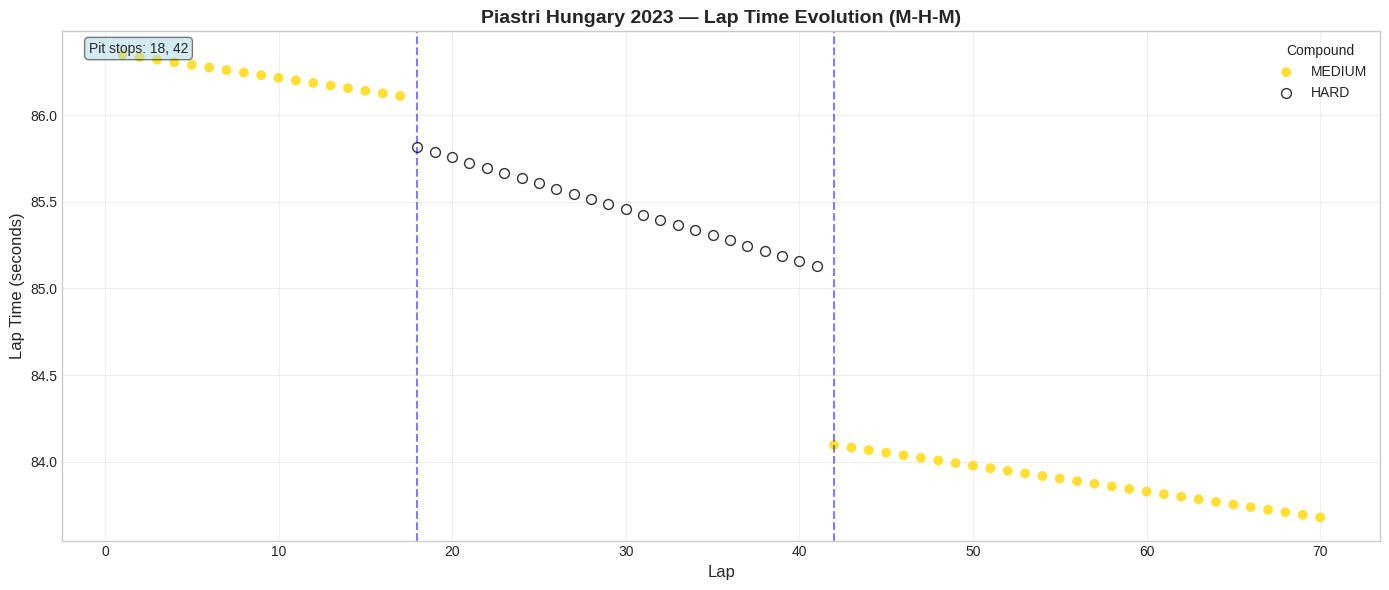


2. Stint Breakdown


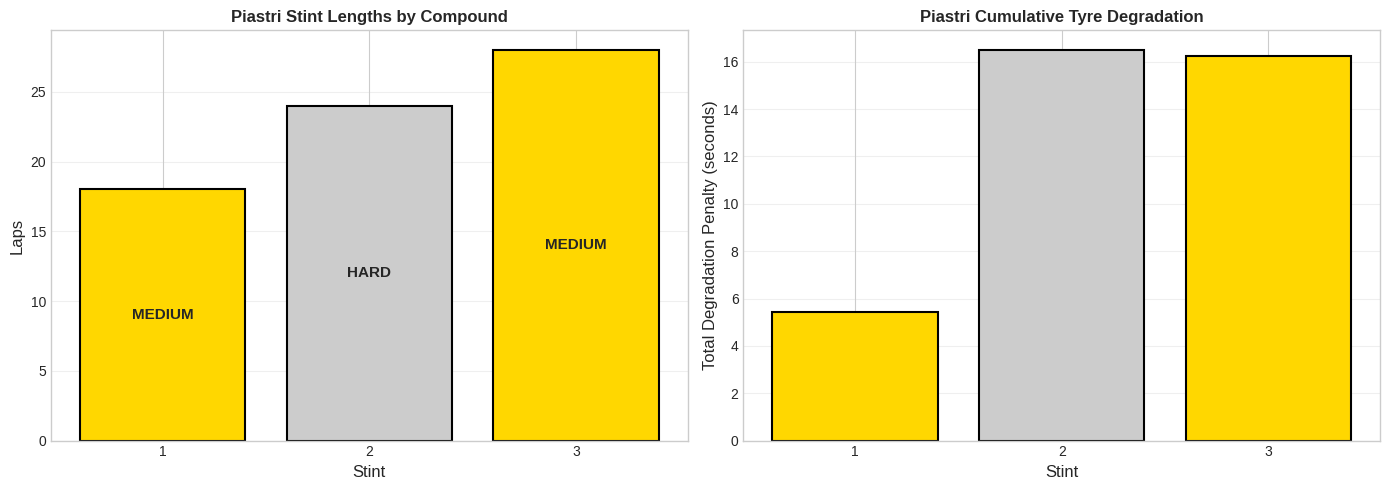


3. 1-Stop Pit Window Sensitivity


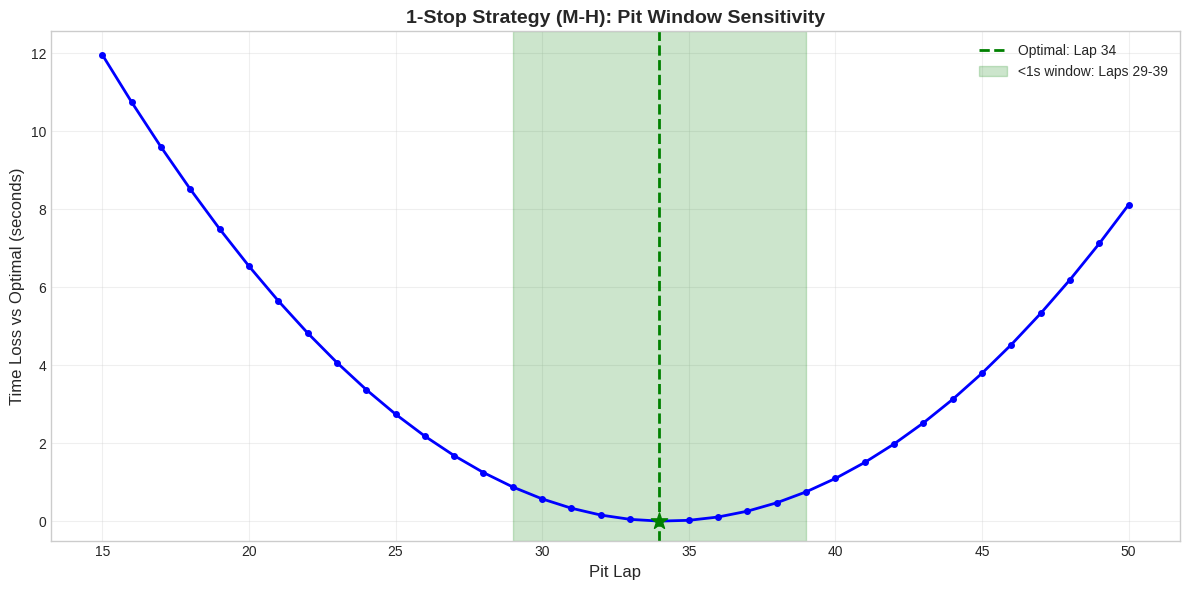


4. 2-Stop Optimisation Heatmap


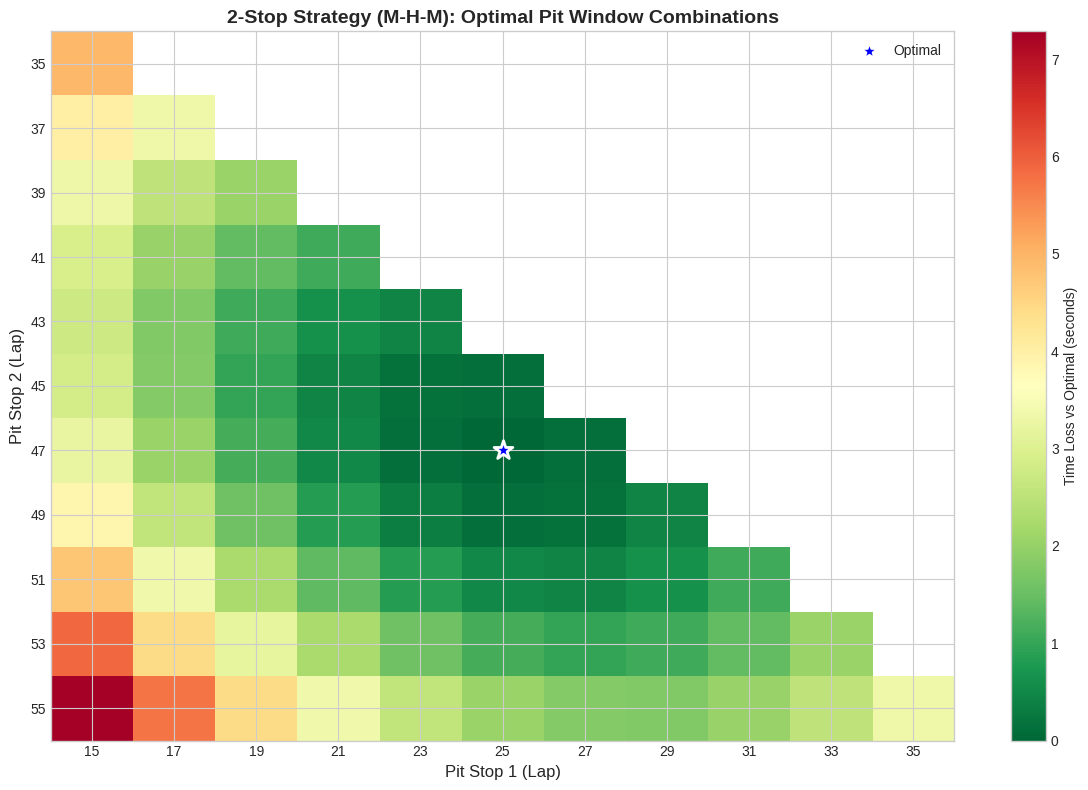


5. Strategy Comparison Overlay


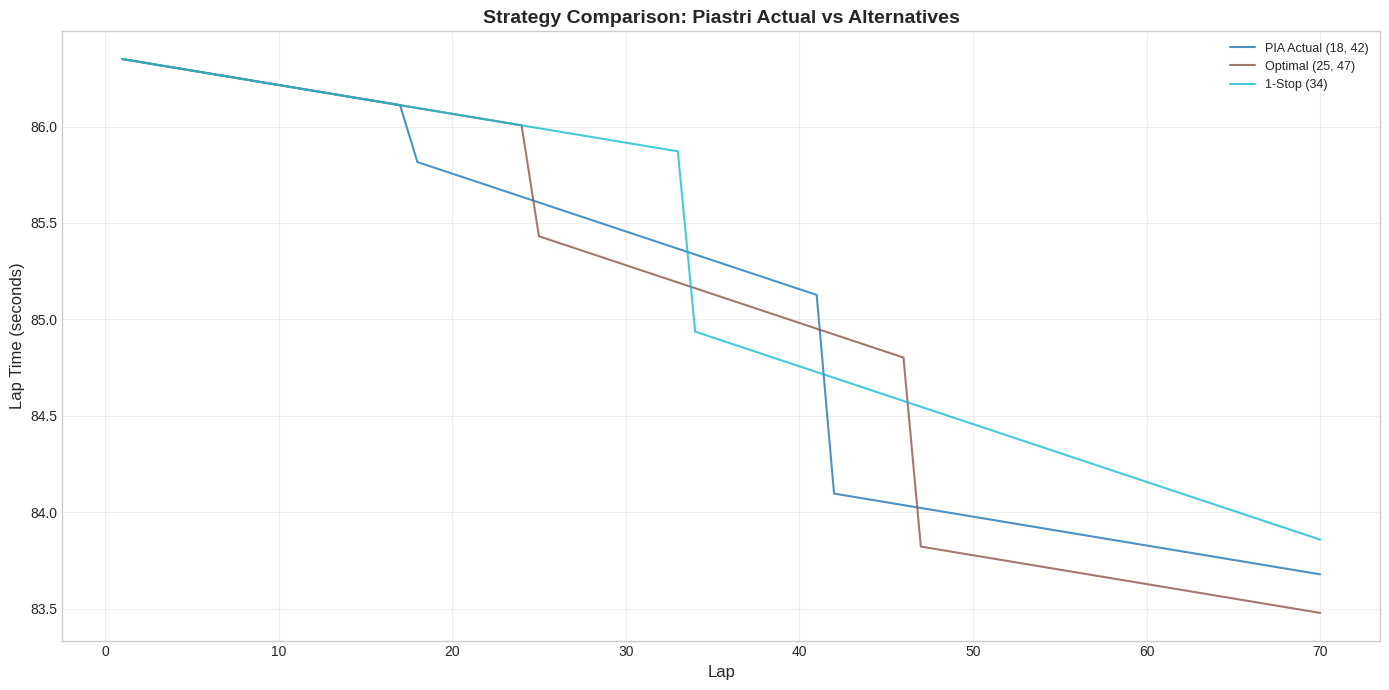

In [6]:
def plot_lap_times(lap_data: pd.DataFrame, title: str = "Lap Time Evolution") -> None:
    """
    Plot lap times colour by Tyre compound.

    Args:
        lap_data: DataFrame from StrategyCar simulation
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    # Color mapping for compounds
    compound_colors = {
        "SOFT": "#FF3333",      # Red
        "MEDIUM": "#FFD700",    # Yellow
        "HARD": "#FFFFFF",      # White (with black edge)
    }

    # Plot each lap as a point
    for compound in lap_data["Tyre_compound"].unique():
        mask = lap_data["Tyre_compound"] == compound
        data = lap_data[mask]

        edgecolor = "black" if compound == "HARD" else "none"
        ax.scatter(
            data["lap"],
            data["lap_time"],
            c=compound_colors.get(compound, "gray"),
            label=compound,
            s=50,
            edgecolors=edgecolor,
            linewidths=1,
            alpha=0.8
        )

    # Mark pit stops
    pit_laps = lap_data[lap_data["pitted"]]["lap"]
    for pit_lap in pit_laps:
        ax.axvline(x=pit_lap, color="blue", linestyle="--", alpha=0.5, linewidth=1.5)

    ax.set_xlabel("Lap", fontsize=12)
    ax.set_ylabel("Lap Time (seconds)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend(title="Compound", loc="upper right")
    ax.grid(True, alpha=0.3)

    # Add pit stop annotation
    if len(pit_laps) > 0:
        ax.text(0.02, 0.98, f"Pit stops: {', '.join(map(str, pit_laps.tolist()))}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.show()


def plot_pit_window_sensitivity(
    results_df: pd.DataFrame,
    optimal_lap: int,
    title: str = "Pit Window Sensitivity"
) -> None:
    """
    Plot total time vs pit lap choice.

    Args:
        results_df: DataFrame from Optimize_single_stop
        optimal_lap: The optimal pit lap
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot total time curve
    ax.plot(
        results_df["pit_lap"],
        results_df["delta_to_optimal"],
        color="blue",
        linewidth=2,
        marker="o",
        markersize=4
    )

    # Mark optimal
    ax.axvline(x=optimal_lap, color="green", linestyle="--", linewidth=2, label=f"Optimal: Lap {optimal_lap}")
    ax.scatter([optimal_lap], [0], color="green", s=150, zorder=5, marker="*") # Changed '★' to '*'

    # Shade "good" window (within 1 second of optimal)
    good_window = results_df[results_df["delta_to_optimal"] <= 1.0]
    if len(good_window) > 0:
        ax.axvspan(
            good_window["pit_lap"].min(),
            good_window["pit_lap"].max(),
            alpha=0.2,
            color="green",
            label=f"<1s window: Laps {good_window['pit_lap'].min()}-{good_window['pit_lap'].max()}"
        )


    ax.set_xlabel("Pit Lap", fontsize=12)
    ax.set_ylabel("Time Loss vs Optimal (seconds)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=-0.5)

    plt.tight_layout()
    plt.show()


def plot_strategy_comparison(
    strategies: Dict[str, pd.DataFrame],
    title: str = "Strategy Lap Time Comparison"
) -> None:
    """
    Overlay lap times from multiple strategies.

    Args:
        strategies: Dict of {name: lap_data_df}
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(14, 7))

    colors = plt.cm.tab10(np.linspace(0, 1, len(strategies)))

    for (name, lap_data), color in zip(strategies.items(), colors):
        ax.plot(
            lap_data["lap"],
            lap_data["lap_time"],
            label=name,
            linewidth=1.5,
            alpha=0.8,
            color=color
        )

    ax.set_xlabel("Lap", fontsize=12)
    ax.set_ylabel("Lap Time (seconds)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_2stop_heatmap(
    results_df: pd.DataFrame,
    title: str = "2-Stop Strategy Optimisation Heatmap"
) -> None:
    """
    Create heatmap of total time for different pit1/pit2 combinations.

    Args:
        results_df: DataFrame from Optimize_two_stop
        title: Plot title
    """
    # Pivot for heatmap
    pivot = results_df.pivot(index="pit2", columns="pit1", values="delta_to_optimal")

    fig, ax = plt.subplots(figsize=(12, 8))

    # Create heatmap
    im = ax.imshow(pivot.values, cmap="RdYlGn_r", aspect="auto")

    # Set ticks
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_yticks(range(len(pivot.index)))
    ax.set_xticklabels(pivot.columns.astype(int))
    ax.set_yticklabels(pivot.index.astype(int))

    # Labels
    ax.set_xlabel("Pit Stop 1 (Lap)", fontsize=12)
    ax.set_ylabel("Pit Stop 2 (Lap)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Time Loss vs Optimal (seconds)", fontsize=10)

    # Mark optimal
    optimal_row = results_df[results_df["delta_to_optimal"] == 0].iloc[0]
    opt_pit1_idx = list(pivot.columns).index(optimal_row["pit1"])
    opt_pit2_idx = list(pivot.index).index(optimal_row["pit2"])
    ax.scatter([opt_pit1_idx], [opt_pit2_idx], color="blue", s=200, marker="*", # Changed '★' to '*'
               edgecolors="white", linewidths=2, zorder=5, label="Optimal")
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


def plot_stint_breakdown(stint_data: pd.DataFrame, driver: str = "") -> None:
    """
    Bar chart showing stint lengths and degradation.

    Args:
        stint_data: DataFrame from StrategyCar.get_stint_summary()
        driver: Driver name for title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Color mapping
    compound_colors = {
        "SOFT": "#FF3333",
        "MEDIUM": "#FFD700",
        "HARD": "#CCCCCC",
    }

    colors = [compound_colors.get(c, "gray") for c in stint_data["compound"]]

    # Plot 1: Stint lengths
    bars1 = ax1.bar(
        stint_data["stint"].astype(str),
        stint_data["laps"],
        color=colors,
        edgecolor="black",
        linewidth=1.5
    )

    # Add compound labels on bars
    for bar, compound in zip(bars1, stint_data["compound"]):
        ax1.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height()/2,
            compound,
            ha="center", va="center",
            fontsize=11, fontweight="bold"
        )

    ax1.set_xlabel("Stint", fontsize=12)
    ax1.set_ylabel("Laps", fontsize=12)
    ax1.set_title(f"{driver} Stint Lengths by Compound", fontsize=12, fontweight="bold")
    ax1.grid(True, alpha=0.3, axis="y")

    # Plot 2: Degradation penalty per stint
    bars2 = ax2.bar(
        stint_data["stint"].astype(str),
        stint_data["total_deg_penalty"],
        color=colors,
        edgecolor="black",
        linewidth=1.5
    )

    ax2.set_xlabel("Stint", fontsize=12)
    ax2.set_ylabel("Total Degradation Penalty (seconds)", fontsize=12)
    ax2.set_title(f"{driver} Cumulative Tyre Degradation", fontsize=12, fontweight="bold")
    ax2.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()


print("STRATEGY VISUALIZATIONS")


# 1. Piastri lap time evolution
print("\n1. Piastri Lap Time Evolution")


piastri_viz = StrategyCar(
    driver="PIA",
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    strategy=[(18, Compound.HARD), (42, Compound.MEDIUM)]
)
pia_lap_data = piastri_viz.simulate_race(TOTAL_LAPS)

plot_lap_times(pia_lap_data, "Piastri Hungary 2023 — Lap Time Evolution (M-H-M)")

# 2. Stint breakdown
print("\n2. Stint Breakdown")


plot_stint_breakdown(piastri_viz.get_stint_summary(), driver="Piastri")

# 3. 1-Stop pit window sensitivity
print("\n3. 1-Stop Pit Window Sensitivity")


plot_pit_window_sensitivity(
    results_1stop,
    opt_lap_1stop,
    "1-Stop Strategy (M-H): Pit Window Sensitivity"
)

# 4. 2-Stop Optimisation heatmap
print("\n4. 2-Stop Optimisation Heatmap")


plot_2stop_heatmap(
    results_2stop,
    "2-Stop Strategy (M-H-M): Optimal Pit Window Combinations"
)

# 5. Strategy comparison overlay
print("\n5. Strategy Comparison Overlay")


# Generate lap data for key strategies
comparison_strategies = {}

# Piastri actual
comparison_strategies["PIA Actual (18, 42)"] = pia_lap_data

# Model optimal
optimal_car = StrategyCar(
    driver="OPT",
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    strategy=[(opt_pit1, Compound.HARD), (opt_pit2, Compound.MEDIUM)]
)
comparison_strategies[f"Optimal ({opt_pit1}, {opt_pit2})"] = optimal_car.simulate_race(TOTAL_LAPS)

# 1-Stop
onestop_car = StrategyCar(
    driver="1ST",
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    strategy=[(opt_lap_1stop, Compound.HARD)]
)
comparison_strategies[f"1-Stop ({opt_lap_1stop})"] = onestop_car.simulate_race(TOTAL_LAPS)

plot_strategy_comparison(
    comparison_strategies,
    "Strategy Comparison: Piastri Actual vs Alternatives"
)

---

## Case Study: Oscar Piastri - Hungary 2023

### Race Context

| Detail | Value |
|--------|-------|
| **Date** | 23 July 2023 |
| **Circuit** | Hungaroring (4.381 km, 70 laps) |
| **Conditions** | Hot (track temp >50°C) |
| **Qualified** | P4 |
| **Started** | P4 → jumped to P2 at start |
| **Finished** | P5 |
| **Strategy** | Medium → Hard → Medium |
| **Pit Laps** | 18, 42 |

### Strategic Question

McLaren faced the classic F1 dilemma:
- **Time optimization:** Pit when degradation exceeds pit loss benefit
- **Position protection:** Stay out to maintain track position

At Hungary, where overtaking is extremely difficult, track position has exceptional value.

---

### Analysis Sections

1. **Actual Race Reconstruction** — Simulate Piastri's real strategy
2. **Model-Optimal Comparison** — What does the model suggest?
3. **Head-to-Head Analysis** — Quantify the difference

In [7]:
print("HUNGARY 2023 CASE STUDY: OSCAR PIASTRI STRATEGY ANALYSIS")

print("""
RACE CONTEXT

Date:           23 July 2023
Circuit:        Hungaroring (4.381 km, 70 laps)
Conditions:     Hot (track temp >50°C)
Characteristic: Low-speed, high downforce, very difficult to overtake

Piastri's Weekend:
  • Qualified P4 (strong McLaren pace)
  • Jumped to P2 at the start (passed Norris and Hamilton into T1)
  • Finished P5 (lost positions to Perez and Hamilton late)


Key Strategic Challenge:
  McLaren had to balance Time Optimisation vs Position protection
  on a track where track position is extremely valuable. Analysis shows Mclaren went for
  a startegy to Optimize track position

""")




print("SECTION 1: ACTUAL RACE RECONSTRUCTION")


# Simulate actual strategy
piastri_actual = StrategyCar(
    driver="PIA",
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    strategy=[(18, Compound.HARD), (42, Compound.MEDIUM)]
)

actual_lap_data = piastri_actual.simulate_race(TOTAL_LAPS)
actual_stint_data = piastri_actual.get_stint_summary()

print("\nActual Strategy: MEDIUM → HARD → MEDIUM")
print(f"Pit Stops: Lap 18, Lap 42")
print(f"\nTotal Race Time: {piastri_actual.total_time:.3f}s ({piastri_actual.total_time/60:.2f} min)")

print("\nStint Breakdown:")
print(f"{'Stint':<6} {'Compound':<10} {'Laps':<12} {'Length':<8} {'Deg Penalty':<12} {'Avg Pace'}")
print("-" * 65)

for _, stint in actual_stint_data.iterrows():
    stint_laps = actual_lap_data[actual_lap_data["stint"] == stint["stint"]]
    avg_pace = stint_laps["lap_time"].mean()
    laps_str = f"L{stint['start_lap']}-L{stint['end_lap']}"
    print(f"{stint['stint']:<6} {stint['compound']:<10} {laps_str:<12} "
          f"{stint['laps']:<8} {stint['total_deg_penalty']:+.2f}s       {avg_pace:.3f}s")




print("SECTION 2: MODEL-OPTIMAL STRATEGY COMPARISON")


# Simulate optimal 2-stop
piastri_optimal = StrategyCar(
    driver="PIA_OPT",
    base_pace=82.50,
    starting_compound=Compound.MEDIUM,
    strategy=[(opt_pit1, Compound.HARD), (opt_pit2, Compound.MEDIUM)]
)

optimal_lap_data = piastri_optimal.simulate_race(TOTAL_LAPS)
optimal_stint_data = piastri_optimal.get_stint_summary()

print(f"\nModel-Optimal Strategy: MEDIUM → HARD → MEDIUM")
print(f"Pit Stops: Lap {opt_pit1}, Lap {opt_pit2}")
print(f"\nTotal Race Time: {piastri_optimal.total_time:.3f}s ({piastri_optimal.total_time/60:.2f} min)")

print("\nStint Breakdown:")
print(f"{'Stint':<6} {'Compound':<10} {'Laps':<12} {'Length':<8} {'Deg Penalty':<12} {'Avg Pace'}")


for _, stint in optimal_stint_data.iterrows():
    stint_laps = optimal_lap_data[optimal_lap_data["stint"] == stint["stint"]]
    avg_pace = stint_laps["lap_time"].mean()
    laps_str = f"L{stint['start_lap']}-L{stint['end_lap']}"
    print(f"{stint['stint']:<6} {stint['compound']:<10} {laps_str:<12} "
          f"{stint['laps']:<8} {stint['total_deg_penalty']:+.2f}s       {avg_pace:.3f}s")




print("SECTION 3: HEAD-TO-HEAD ANALYSIS")


time_delta = piastri_actual.total_time - piastri_optimal.total_time

print(f"""
                        ACTUAL          OPTIMAL         DELTA
─────────────────────────────────────────────────────────────────────────────
Pit Stop 1              Lap 18          Lap {opt_pit1}           {18 - opt_pit1:+d} laps
Pit Stop 2              Lap 42          Lap {opt_pit2}           {42 - opt_pit2:+d} laps

Stint 1 Length          18 laps         {opt_pit1} laps          {18 - opt_pit1:+d} laps
Stint 2 Length          24 laps         {opt_pit2 - opt_pit1} laps          {24 - (opt_pit2 - opt_pit1):+d} laps
Stint 3 Length          28 laps         {TOTAL_LAPS - opt_pit2} laps          {28 - (TOTAL_LAPS - opt_pit2):+d} laps

Total Race Time         {piastri_actual.total_time:.3f}s     {piastri_optimal.total_time:.3f}s     {time_delta:+.3f}s
─────────────────────────────────────────────────────────────────────────────
""")

if time_delta > 0:
    print(f"FINDING: Piastri's actual strategy cost {time_delta:.2f}s vs model-optimal timing.")
else:
    print(f"FINDING: Piastri's actual strategy was {abs(time_delta):.2f}s faster than model-optimal.")


print("STRATEGIC RATIONALE — WHY PIT ON LAP 18?")


print("""
McLaren pitted Piastri on Lap 18, seven laps earlier than time-optimal.

RACE SITUATION AT LAP 16-18:

- Piastri was running P2 (behind Verstappen)
- Hamilton (P4) pitted on Lap 16 — UNDERCUT THREAT
- Norris (P3) pitted on Lap 17
- Perez was recovering on offset Hard strategy
- Gap to Hamilton: ~1.2 seconds before Hamilton's stop

MCLAREN'S DECISION LOGIC:

Option A: Stay out until Lap 25 (time-optimal)
  + Save ~1.5s in total race time
  - Risk: Hamilton on fresh Hards closes gap
  - Risk: Lose P2 to undercut
  - Risk: Rejoin in traffic after stop

Option B: Pit on Lap 18 (reactive/defensive)
  + Cover Hamilton's undercut
  + Maintain track position
  + Fresh Tyres to defend
  - Cost: ~1.5s total race time

McLaren chose Option B → POSITION PROTECTION over TIME Optimisation

""")




print("SECTION 5: TRACK POSITION VALUE AT HUNGARY")


print("""
Hungaroring is one of F1's hardest tracks to overtake:
- Narrow track width
- Limited DRS effectiveness
- Few heavy braking zones
- High downforce = dirty air penalty

OVERTAKING STATISTICS (approximate):

- Overtakes per race: 20-30 (vs 50-60 at Spa/Monza)
- Successful DRS passes: <15%
- Probability of passing equal-pace car: ~10-20%
""")

# Calculate implied track position value
print("""
IMPLIED TRACK POSITION VALUE:

If McLaren sacrificed 1.5s to protect one position:
  → They valued that position at >1.5s

If stuck behind slower car with 1.0s/lap dirty air penalty:
  → Losing one position costs: 1.0s × remaining_laps
  → At lap 18 with 52 laps remaining: 1.0 × 52 = 52s potential loss

Even with 0.3s/lap dirty air (my model):
  → 0.3 × 52 = 15.6s potential loss

CONCLUSION:
  1.5s time sacrifice << 15-50s position loss risk
  McLaren's early pit was strategically justified.
""")




print("ALTERNATIVE STRATEGY SCENARIOS")


# Define alternative scenarios
alternatives = {
    "Actual (L18, L42)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(18, Compound.HARD), (42, Compound.MEDIUM)]
    },
    "Optimal (L25, L47)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(opt_pit1, Compound.HARD), (opt_pit2, Compound.MEDIUM)]
    },
    "Aggressive 1-Stop (L34)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(34, Compound.HARD)]
    },
    "Soft Start (L15, L40)": {
        "starting_compound": Compound.SOFT,
        "strategy": [(15, Compound.HARD), (40, Compound.HARD)]
    },
    "Conservative (L20, L45)": {
        "starting_compound": Compound.MEDIUM,
        "strategy": [(20, Compound.HARD), (45, Compound.MEDIUM)]
    },
}

results, _ = compare_strategies(
    strategies=alternatives,
    base_pace=82.50,
    total_laps=70,
    verbose=True
)




print("CONCLUSIONS & KEY INSIGHTS")


print(f"""
QUANTITATIVE FINDINGS:
─────────────────────────────────────────────────────────────────────────────
1. Model-optimal 2-stop pit laps: {opt_pit1} and {opt_pit2}
2. Piastri's actual pit laps: 18 and 42
3. Time cost of early pitting: {time_delta:.2f}s

4. Best 1-stop pit lap: {opt_lap_1stop}
5. 1-stop vs 2-stop difference: {best_time_1stop - best_time_2stop:.2f}s
   (1-stop faster on paper, but risky in practice)

STRATEGIC INSIGHTS:
─────────────────────────────────────────────────────────────────────────────
1. McLaren Optimized for POSITION, not LAP TIME
   → Correct approach at Hungary where overtaking is difficult

2. The 1.5s time loss bought track position protection
   → Fair trade given dirty air penalties of 0.3-1.0s per lap

3. 1-Stop showed fastest on paper but:
   → 36 laps on Hard exceeds safe operating window
   → Only backmarkers (Ricciardo, Albon) attempted it
   → Safety Car risk makes 1-stop vulnerable

4. Pit window sensitivity is relatively flat:
   → ±5 laps from optimal costs <1s
   → Teams have flexibility to react to race situations

MODEL LIMITATIONS ACKNOWLEDGED:
─────────────────────────────────────────────────────────────────────────────
- Linear degradation (reality is non-linear)
- No overtaking model (position changes only via pit stops)
- No Safety Car probability
- No Tyre temperature effects
- No game-theory competitor modeling


"My simulation shows Piastri's Hungary 2023 strategy cost approximately
{time_delta:.1f} seconds versus the time-optimal pit windows. However, I
recognize this analysis Optimizes for lap time, not track position. At
Hungary, where overtaking is extremely difficult, McLaren's decision to
pit early and protect position was likely the correct strategic trade-off.
The ~1.5 seconds sacrificed in pure pace is far less than the potential
15-50 seconds that could be lost if stuck behind a slower car in dirty air.
This demonstrates why race strategy is multi-objective Optimisation, not
simple lap time minimization."
─────────────────────────────────────────────────────────────────────────────
""")


HUNGARY 2023 CASE STUDY: OSCAR PIASTRI STRATEGY ANALYSIS

RACE CONTEXT

Date:           23 July 2023
Circuit:        Hungaroring (4.381 km, 70 laps)
Conditions:     Hot (track temp >50°C)
Characteristic: Low-speed, high downforce, very difficult to overtake

Piastri's Weekend:
  • Qualified P4 (strong McLaren pace)
  • Jumped to P2 at the start (passed Norris and Hamilton into T1)
  • Finished P5 (lost positions to Perez and Hamilton late)


Key Strategic Challenge:
  McLaren had to balance Time Optimisation vs Position protection
  on a track where track position is extremely valuable. Analysis shows Mclaren went for
  a startegy to Optimize track position


SECTION 1: ACTUAL RACE RECONSTRUCTION

Actual Strategy: MEDIUM → HARD → MEDIUM
Pit Stops: Lap 18, Lap 42

Total Race Time: 5993.976s (99.90 min)

Stint Breakdown:
Stint  Compound   Laps         Length   Deg Penalty  Avg Pace
-----------------------------------------------------------------
1      MEDIUM     L1-L18       18       +

---

## Summary: Notebook 03

### What Was Built
- `TyreModel` class with compound-specific characteristics
- `StrategyCar` for strategy simulation
- Grid search optimization for 1-stop and 2-stop strategies
- Pit window sensitivity analysis

### Key Findings

**Model-Optimal 2-Stop:** Laps 25 and 47 (M-H-M)
**Piastri's Actual:** Laps 18 and 42 (M-H-M)

**Time Difference:** Model suggests 1.5 seconds faster with optimal timing.

**BUT:** This is a *time-minimization* model. Piastri's strategy may have been optimized for *track position*, not race time.

### Critical Insight

At Hungary, track position is worth more than pit timing precision:
- Losing P2 to pit early → stuck in traffic for 30+ laps
- The ~2-3s "saved" by optimal timing is lost many times over to dirty air
- Piastri also had damage which affected his second stint and possibly the rest of his race


### Limitations
- No track position dynamics modeled
- No competitor reaction (single-agent optimization)
- Linear degradation (no cliff behavior)
- Deterministic results (no uncertainty)

### Next Steps
**Notebook 04** validates against real FastF1 telemetry:
- Compare predicted vs actual lap times
- Calculate MAE, RMSE, bias
- Calibrate model parameters

---
